## LSTM

Source: [https://cnvrg.io/pytorch-lstm/]

Basically a NN for sequential data.

You'll see below that for the testing data, the predicted stock prices aren't super accurate but the model identifies the trend of the stock pretty well.

This research is also for a single stock. Need to figure out how to train a LSTM using multiple stocks due to sequential data.

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable 
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [77]:
%load_ext autoreload
%autoreload 2
from lstm_model import LSTMModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create Data

In [78]:
ticker = 'XOM'
start_date = '2014-01-01'
end_date = '2024-01-01'

data = yf.download(ticker, start=start_date, end=end_date)

# Calculate moving averages and std
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['Std_Dev'] = data['Close'].rolling(window=20).std()

# Calculate the z-score
data['Z_Score'] = (data['Close'] - data['SMA_20']) / data['Std_Dev']

# Calculate RSI
delta = data['Close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up / ema_down

data['RSI'] = 100 - (100 / (1 + rs))

# Calculate the daily returns
data['Returns'] = data['Close'].pct_change()

# If stock price goes up or down
data['Target'] = data['Close'].shift(-1)

data.dropna(inplace=True)

# Wanted features for X and y
features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Close', 'Returns']
X = data.loc[:, features]
y = data.iloc[:, (data.shape[1]-1):(data.shape[1])]

[*********************100%%**********************]  1 of 1 completed


### Scale Data

In [79]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mm = MinMaxScaler()
ss = StandardScaler()
# mm2 = MinMaxScaler()
# ss2 = StandardScaler()

X_ss = pd.DataFrame(ss.fit_transform(X), index=X.index, columns=X.columns)
y_mm = pd.DataFrame(mm.fit_transform(y), index=y.index, columns=y.columns)

# Split data into first 80% and last 20%
X_train, X_test, y_train, y_test = train_test_split(X_ss, y_mm, test_size=0.2, random_state=42, shuffle=False)
# X_train_ss = pd.DataFrame(ss1.fit_transform(X_train), index=X_train.index, columns=X.columns)
# y_train_mm = pd.DataFrame(mm1.fit_transform(y_train), index=y_train.index, columns=y.columns)
# X_test_ss = pd.DataFrame(ss2.fit_transform(X_test), index=X_test.index, columns=X.columns)
# y_test_mm = pd.DataFrame(mm2.fit_transform(y_test), index=y_test.index, columns=y.columns)

## Prepare Data for LSTM

Converts the Numpy Arrays to Tensors and to Variables (which can be differentiated).

In [80]:
features_ = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI'] # Features to train with.
X_train_tensors = Variable(torch.Tensor(np.array(X_train[features_])))
X_test_tensors = Variable(torch.Tensor(np.array(X_test[features_])))

y_train_tensors = Variable(torch.Tensor(y_train.values))
y_test_tensors = Variable(torch.Tensor(y_test.values))

X_train_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [81]:
print("Training Shape", X_train_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([1972, 1, 5]) torch.Size([1972, 1])
Testing Shape torch.Size([494, 1, 5]) torch.Size([494, 1])


### Training

In [82]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [83]:
lstm = LSTMModel(num_classes, input_size, hidden_size, num_layers, X_train_final.shape[1]) #our lstm class 

In [84]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) # ADAM optimizer

In [85]:
for epoch in range(num_epochs):
  outputs = lstm.forward(X_train_final) #forward pass
  optimizer.zero_grad() #calculate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.30551
Epoch: 100, loss: 0.02213
Epoch: 200, loss: 0.00475
Epoch: 300, loss: 0.00253
Epoch: 400, loss: 0.00107
Epoch: 500, loss: 0.00056
Epoch: 600, loss: 0.00037
Epoch: 700, loss: 0.00030
Epoch: 800, loss: 0.00027
Epoch: 900, loss: 0.00026


In [86]:
train_predict = lstm(X_train_final) # predictions
data_predict = train_predict.data.numpy() # predictions to numpy

In [87]:
# run these once
data_predict = mm.inverse_transform(data_predict) # reverse transformation
X_train = pd.DataFrame(ss.inverse_transform(X_train), index=X_train.index, columns=features) # reverse transformation for training data

Accuracy: 0.9325557809330629


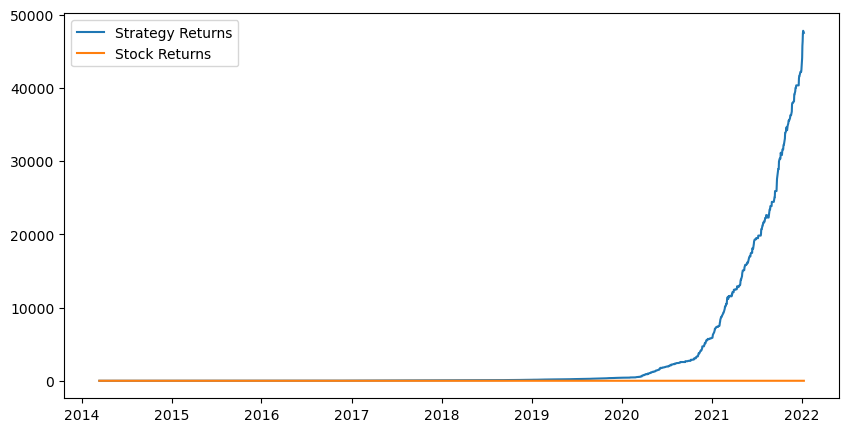

In [88]:
X_train['Predicted_Price'] = data_predict
X_train['Actual_Signal'] = (X_train['Returns'].shift(-1) > 0).astype(int) # actual signal, 1 if next-day returns > 0, 0 if next-day returns <= 0
X_train['Predicted_Returns'] = X_train['Predicted_Price'].pct_change() # calculate returns of predicted stock price
X_train['Predicted_Signal'] = (X_train['Predicted_Returns'].shift(-1) > 0).astype(int) # predicted signal based on predicted returns
X_train['Strategy_Returns'] = X_train['Returns'] * X_train['Predicted_Signal'].shift(1) # strategy returns
cumulative_strategy_returns = (X_train['Strategy_Returns'].fillna(0) + 1).cumprod()
returns = X_train.loc[X_train.index, 'Returns']
returns.iloc[0] = 0 # set the first actual return to 0 to ensure that both plots start at 1.
cumulative_stock_returns = (returns + 1).cumprod() # returns of the stock (basically if we held the stock for the entire duration)
accuracy = (X_train['Actual_Signal'] == X_train['Predicted_Signal']).mean() # accuracy of predicted signal
print(f'Accuracy: {accuracy}')

plt.figure(figsize=(10,5))
plt.plot(cumulative_strategy_returns, label='Strategy Returns')
plt.plot(cumulative_stock_returns, label='Stock Returns')
plt.legend();

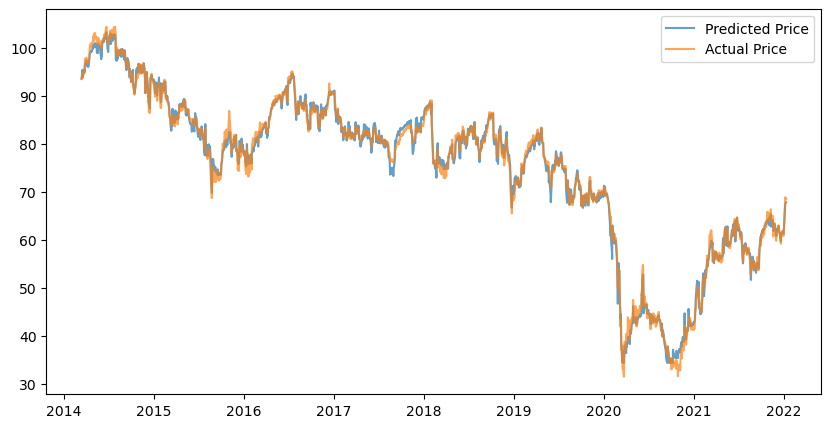

In [89]:
plt.figure(figsize=(10,5))
plt.plot(X_train['Predicted_Price'], label='Predicted Price', alpha=0.7)
plt.plot(X_train['Close'], label='Actual Price', alpha=0.7)
plt.legend();

In [90]:
test_predict = lstm(X_test_final)
data_predict = test_predict.data.numpy()

In [91]:
data_predict = mm.inverse_transform(data_predict)
X_test = pd.DataFrame(ss.inverse_transform(X_test), index=X_test.index, columns=features)

Accuracy: 0.9412955465587044


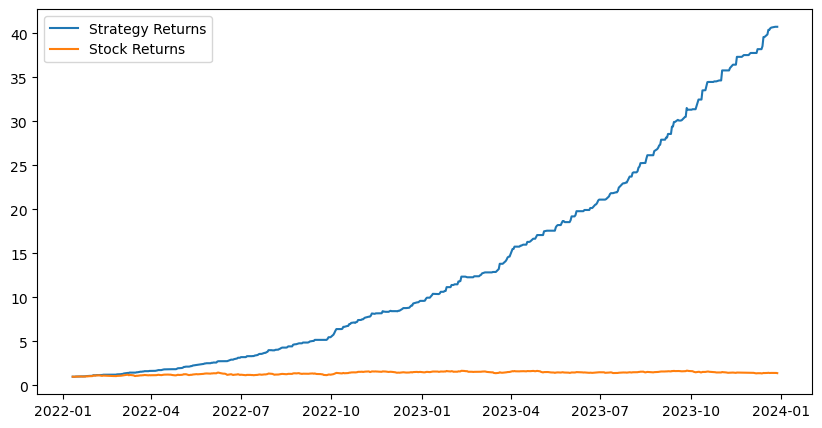

In [92]:
X_test['Actual_Signal'] = (X_test['Returns'].shift(-1) > 0).astype(int)
X_test['Predicted_Price'] = data_predict
X_test['Predicted_Returns'] = X_test['Predicted_Price'].pct_change()
X_test['Predicted_Signal'] = (X_test['Predicted_Returns'].shift(-1) > 0).astype(int)
X_test['Strategy_Returns'] = X_test['Returns'] * X_test['Predicted_Signal'].shift(1)
cumulative_strategy_returns = (X_test['Strategy_Returns'].fillna(0) + 1).cumprod()
returns = X_test.loc[X_test.index, 'Returns']
returns.iloc[0] = 0
cumulative_stock_returns = (returns + 1).cumprod()
accuracy = (X_test['Actual_Signal'] == X_test['Predicted_Signal']).mean()
print(f'Accuracy: {accuracy}')
# Calculate cumulative returns for the market
#market_data['Returns'] = market_data['Close'].pct_change()
#cumulative_market_returns = (market_data['Returns'].fillna(0) + 1).cumprod()

plt.figure(figsize=(10,5))

plt.plot(cumulative_strategy_returns, label='Strategy Returns')
#plt.plot(cumulative_market_returns, label='Market Returns')
plt.plot(cumulative_stock_returns, label='Stock Returns')
plt.legend();

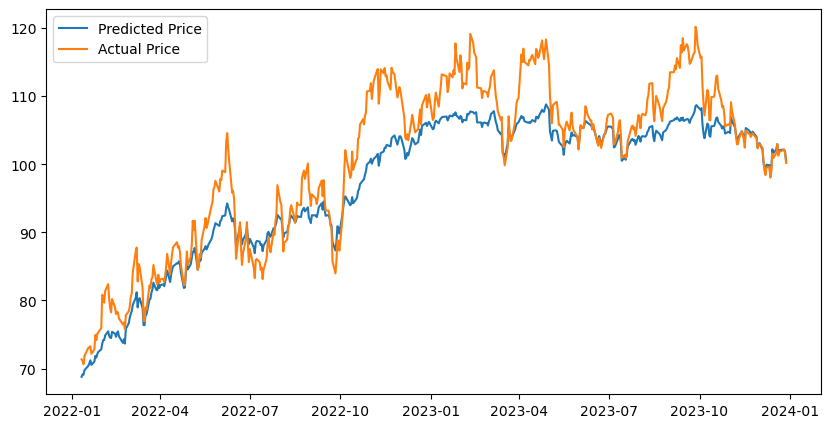

In [93]:
plt.figure(figsize=(10,5))
plt.plot(X_test['Predicted_Price'], label='Predicted Price')
plt.plot(X_test['Close'], label='Actual Price')
plt.legend();